# Forecast Carbon Emission
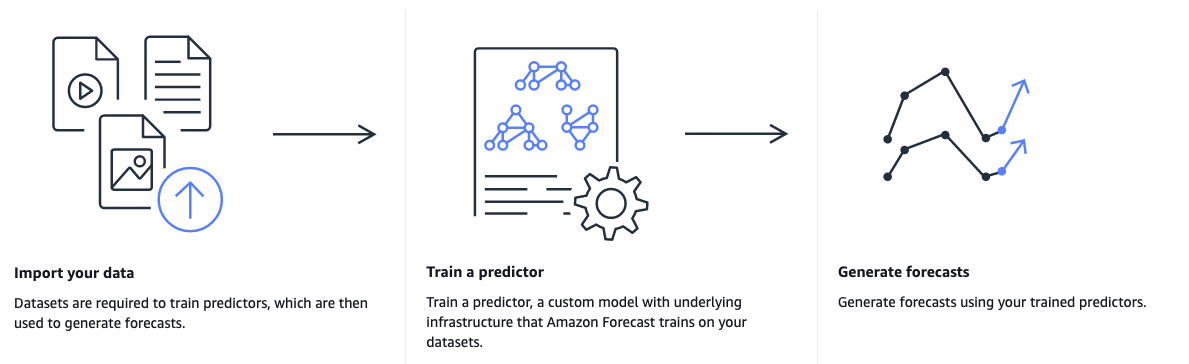


#### This Notebook will enable you to read the data from Carbon Lake "Enriched" bucket and transform it into a Amazon-Forecast-ready datasets

In [176]:
#Install Required Libraries
#!pip install pandas s3fs matplotlib ipywidgets boto3 dask aiobotocore awswrangler

# Python libraries:
import datetime
import os
import random
import sys
import time
import boto3  # The AWS SDK for Python
from dateutil.relativedelta import relativedelta
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np  # Numerical processing
import pandas as pd  # Dataframe (tabular data) processing
import seaborn as sns  # Graph plotting
import glob
from time import sleep
import subprocess
import json
import pprint
import dateutil.parser
from pathlib import Path
import awswrangler as wr
from aiobotocore.session import AioSession


# Create unique S3 bucket for saving your own data

In [177]:
#Get your AWS account ID to create a unique s3 bukcet
region = boto3.Session("s3").region_name
print(f"region = {region}")
account_id = boto3.client('sts').get_caller_identity().get('Account')
s3_client = boto3.client('s3')

# create unique S3 bucket for saving forecast output data
bucket_name = 'carbon-lake-forecast-results-' + account_id 
print(f"bucket_name = {bucket_name}")

#create_bucket
s3_client.create_bucket(Bucket=bucket_name)

# create prefix for organizing your new bucket and a folder for local files
prefix = "data"
print(f"using folder '{prefix}'")
os.makedirs("data", exist_ok=True)

region = us-east-1
bucket_name = carbon-lake-forecast-results-354473994411
using folder 'data'


# Load the raw data from "Enriched" bucket

In [178]:
enriched_bucket = 's3://carbon-lake-enriched-data-4969'
date_format = '%Y-%m'
# What is your forecast time unit granularity?
FORECAST_FREQ = "M"
# what is your forecast horizon in number time units you've selected?
FORECAST_LENGTH = 12
role_arn = "arn:aws:iam::354473994411:role/ForecastRole"
role_name = role_arn.split("/")[1]

#read the enriched parquet file
df = wr.s3.read_parquet(enriched_bucket)

#Drop duplicates
df.drop_duplicates(inplace=True)

#Replace NA with 0
df.fillna(0)

#Change Data Types
df['raw_data'] = pd.to_numeric(df['raw_data'],downcast='float')
df['calculated_emissions_co2'] = pd.to_numeric(df['calculated_emissions_co2'],downcast='float')
df['origin_measurement_timestamp'] = pd.to_datetime(df["origin_measurement_timestamp"], format=date_format, errors='coerce')
start_time = df.origin_measurement_timestamp.min()
end_time = df.origin_measurement_timestamp.max()
print(f"Min timestamp = {start_time}")
print(f"Max timestamp = {end_time}")

Min timestamp = 2019-01-01 00:00:00
Max timestamp = 2021-12-01 00:00:00


### Aggregate the emissions at monthly-level for each asset

In [179]:
# Extract the month-year from the 'origin_measurement_timestamp'
df['origin_measurement_timestamp'] = df['origin_measurement_timestamp'].astype('datetime64[M]')

#Filter the necessary attributes required for timeseries forecasting
df_filtered = df[['asset_id',
    'origin_measurement_timestamp',
    'calculated_emissions_co2']]

# Aggregate emmisions monthly for each asset_id
agg_func_math = {
    'asset_id': ['first'],
    'origin_measurement_timestamp':['first'],
    'calculated_emissions_co2':['sum'],
}
#Aggregate monthly and have the forecast ready data
df_monthly_aggregated = df_filtered.groupby(['asset_id','origin_measurement_timestamp'],as_index=False).agg(agg_func_math).round(2)

df_filtered = pd.DataFrame(data=df_monthly_aggregated)
df_filtered.columns =['asset_id','origin_measurement_timestamp','calculated_emissions_co2']
df_filtered['origin_measurement_timestamp'] = pd.to_datetime(df_filtered["origin_measurement_timestamp"])

# map expected column names
item_id = "asset_id"
target_value = "calculated_emissions_co2"
timestamp = "origin_measurement_timestamp"
location_id = None
geolocation = None

if location_id is None:
    use_location = False
else:
    use_location = True
print(f"use_location = {use_location}")

# specify array of dimensions you'll use for forecasting
if use_location:
    forecast_dims = [timestamp, location_id, item_id]
else:
    forecast_dims = [timestamp, item_id]
print(f"forecast_dims = {forecast_dims}")
dims_except_timestamp = [i for i in forecast_dims if i != timestamp]
print(f"dims_except_timestamp = {dims_except_timestamp}")

use_location = False
forecast_dims = ['origin_measurement_timestamp', 'asset_id']
dims_except_timestamp = ['asset_id']


In [102]:
target_to_integer = False
replace_all_zeroes_with_null = False
replace_extremes_with_mean = False
create_future_RTS_with_unknown_data = False
AF_freq_to_dateutil_freq = {"Y":"years", "M":"months", "W":"weeks", "D":"days", "H":"hours"}

end_time_train = df_filtered[timestamp].max() - relativedelta(months=FORECAST_LENGTH)
print(end_time_train)
snapshot_date = end_time_train.date() + relativedelta(months=1)
print(f"Suggested snapshot date = {snapshot_date}")
SNAPSHOT_DATE = snapshot_date
EXPERIMENT_NAME = "co2_emission_forecast"
DATA_VERSION = 1

# print some validation back to user
print(f"Convert your frequency to python dateutil = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
print(f"Forecast horizon = {FORECAST_LENGTH} {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
snapshot_end = SNAPSHOT_DATE + relativedelta(months=+FORECAST_LENGTH)
snapshot_end = snapshot_end - relativedelta(months=1)
print(f"Training data end date = {end_time_train}")
print(f"Forecast start date = {SNAPSHOT_DATE}")
print(f"Forecast end date = {snapshot_end}")
start_time = df_forecast_ready[timestamp].min()
end_time = snapshot_end

snapshot_date_monthYear = SNAPSHOT_DATE.strftime("%m%Y")
EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_snap_{snapshot_date_monthYear}_{FORECAST_LENGTH}_{FORECAST_FREQ}"
print(f"Experiment name = {EXPERIMENT_NAME}")

2020-12-01 00:00:00
Suggested snapshot date = 2021-01-01
Convert your frequency to python dateutil = months
Forecast horizon = 12 months
Training data end date = 2020-12-01 00:00:00
Forecast start date = 2021-01-01
Forecast end date = 2021-12-01
Experiment name = co2_emission_forecast_snap_012021_12_M


# Data Quality Check
Perform below quality checks 
1) Drop readings with NULL value (both for timestamp and item_id)
2) Inspect and treat extreme emissions
3) Remove any readings with negative value

Number unique items: 4
Number nulls: 0
<StringArray>
['vehicle100', 'vehicle101', 'vehicle102', 'vehicle103']
Length: 4, dtype: string
No missing item_ids found.
Number nulls: 0
No null timestamps found.
166.8087106109619
Number extremes: 1
           origin_measurement_timestamp  calculated_emissions_co2
asset_id                                                         
vehicle103                   2019-04-01                166.809998
(0, 3)
No negative values found.


,asset_id


No time series found with only 0's.
Didn't drop anything


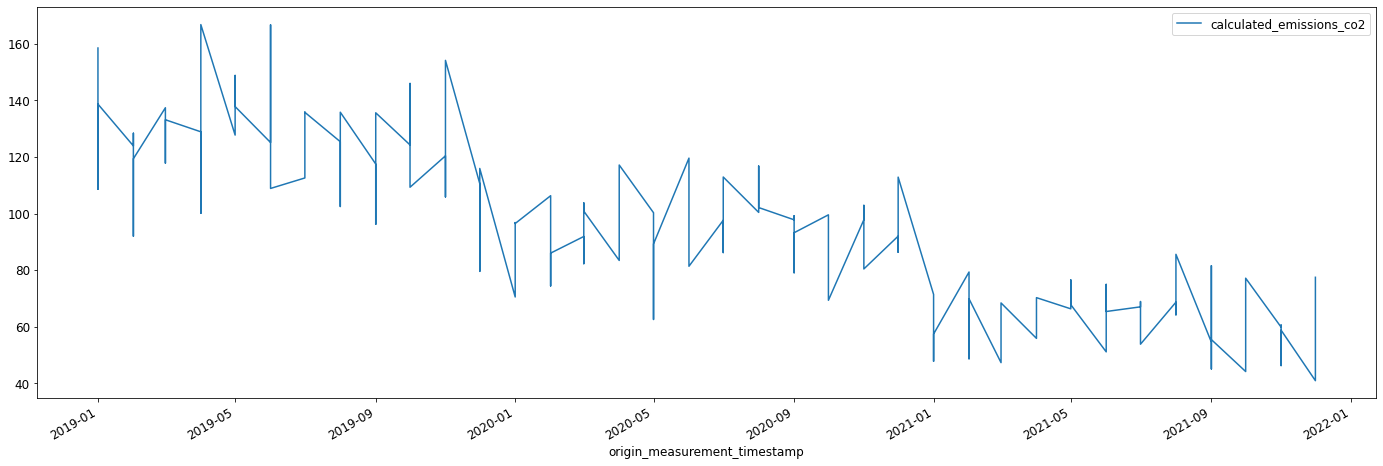

In [183]:
#Drop null items
templist = df_filtered[item_id].unique()
print(f"Number unique items: {len(templist)}")
print(f"Number nulls: {pd.isnull(templist).sum()}")

if len(templist) < 20:
    print(templist)
    
## Drop the null item_ids, if any exist
if pd.isnull(templist).sum() > 0:
    print(df_filtered.shape)
    df_filtered = df_filtered.loc[(~df_filtered[item_id].isna()), :].copy()
    print(df_filtered.shape)
    print(len(df_filtered[item_id].unique()))
else:
    print("No missing item_ids found.")

#Drop null time stamps
# check null timestamps
templist = df_filtered.loc[(df_filtered[timestamp].isna()), :].shape[0]
print(f"Number nulls: {templist}")

if (templist < 10) & (templist > 0) :
    print(df_filtered.loc[(df_filtered[timestamp].isna()), :])

## Drop the null quantities and dates
if templist > 0:
    print(df_filtered.shape)
    df_filtered = df_filtered.loc[(~df_filtered[timestamp].isna()), :].copy()
    print(df_filtered.shape)
    print(df_filtered['timestamp'].isna().sum())
else:
    print("No null timestamps found.")
    
# Inspect (and treat) extremes 
# Decide how many extreme values is considered unusual
MAX_EXTREMES = 10
EXTREME_VALUE = df_filtered[target_value].quantile(0.9999)
print(EXTREME_VALUE)

# Inspect extremes
templist = df_filtered.loc[(df_filtered[target_value]>=EXTREME_VALUE), :].shape[0]
print(f"Number extremes: {templist}")

if (templist < MAX_EXTREMES) & (templist > 0) :
    print(df_filtered.loc[(df_filtered[target_value]>=EXTREME_VALUE), :].set_index([item_id]))

replace_extremes_with_mean = False
## PLOT OVERALL TIME SERIES - TO HELP INSPECT EXTREMES
df_filtered.plot(x=timestamp, y=target_value, figsize=(24, 8))


# Check negative values
df_clean = df_filtered.copy()
print(df_clean.loc[(df_clean[target_value] <0), :].shape)
df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

# If negative values found, round them up to 0
if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

    # Check y-value before cleaning
    print(df_clean[target_value].describe())

    # default negative values in demand to 0
    print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
    print()
    ts_cols = [target_value]

    for c in ts_cols:
        df_clean.loc[(df_clean[c] < 0.0), c] = 0.0

    # Check y-value after cleaning
    print(df_clean[target_value].describe())
else:
    print("No negative values found.")

# check if sum of all emission is 0
tts = df_clean
g = tts.groupby(dims_except_timestamp).sum()
g.fillna(0, inplace=True)
assests_with_no_emission = g[g[target_value] == 0].copy()

# drop extra columns for cleaner merge
assests_with_no_emission.reset_index(inplace=True)
assests_with_no_emission = assests_with_no_emission.iloc[:, 0:1]
assests_with_no_emission.drop_duplicates(inplace=True)
display (assests_with_no_emission.head(2))

if assests_with_no_emission.shape[0] > 0:
        
    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(assests_with_no_emission, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with only 0's.")

# really drop assets with only 0's

if assests_with_no_emission.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    assests_with_no_emission = assests_with_no_emission[dims_except_timestamp].copy()
    
    # save the reason
    assests_with_no_emission['reason'] = "All 0's"
    display(assests_with_no_emission.head(2))
    
    print(tts.shape)
    display(tts.sample(5))

else:
    print("Didn't drop anything")

## Make sure the Assets have enough emission readings for making meaningful forecast prediction

In [184]:
# check per time series if count of data points is at least 12
g = tts.groupby(dims_except_timestamp).count()
assests_with_few_emission = g[g[target_value] < 12].copy()

# drop extra columns for cleaner merge
assests_with_few_emission.reset_index(inplace=True)
assests_with_few_emission = assests_with_few_emission.iloc[:, 0:1]
assests_with_few_emission.drop_duplicates(inplace=True)
print(len(assests_with_few_emission))
display(assests_with_few_emission.head(20))

if assests_with_few_emission.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(assests_with_few_emission, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print("TTS if you dropped items with too few data points")
    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with fewer than 44 datapoints.")

# really drop skus with too few data points, only if more than a handful found

if assests_with_few_emission.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    assests_with_few_emission = assests_with_few_emission[dims_except_timestamp].copy()
    assests_with_few_emission['reason'] = "Fewer than 44 datapoints"
    display(assests_with_few_emission.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")
    
    
if assests_with_few_emission.shape[0] > 0:
    dropped_dims = assests_with_few_emission.append([assests_with_few_emission])
    print(f"unique ts dropped = {dropped_dims.shape[0]}")
    print(f"unique ts fewer than 12 data points = {assests_with_few_emission.shape[0]}")
    print(f"unique ts with all 0s = {assests_with_few_emission.shape[0]}")
    display(dropped_dims.reason.value_counts(dropna=False, normalize=True))
    display(dropped_dims.sample(1))
else:
    print("Didn't drop anything")
# save list of dropped skus and reasons for reference and to check if data can be fixed

if assests_with_few_emission.shape[0] > 2:
    # save all the dropped dimensions fields
    local_file = "data/dropped_fields.csv"
    # Save merged file locally
    dropped_dims.to_csv(local_file, header=True, index=False)

    key = f"{prefix}/v{DATA_VERSION}/dropped_{EXPERIMENT_NAME}.csv"
    boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)


0


,asset_id


No time series found with fewer than 44 datapoints.
Didn't drop anything
Didn't drop anything


## Visualize historical emission of a sample assest

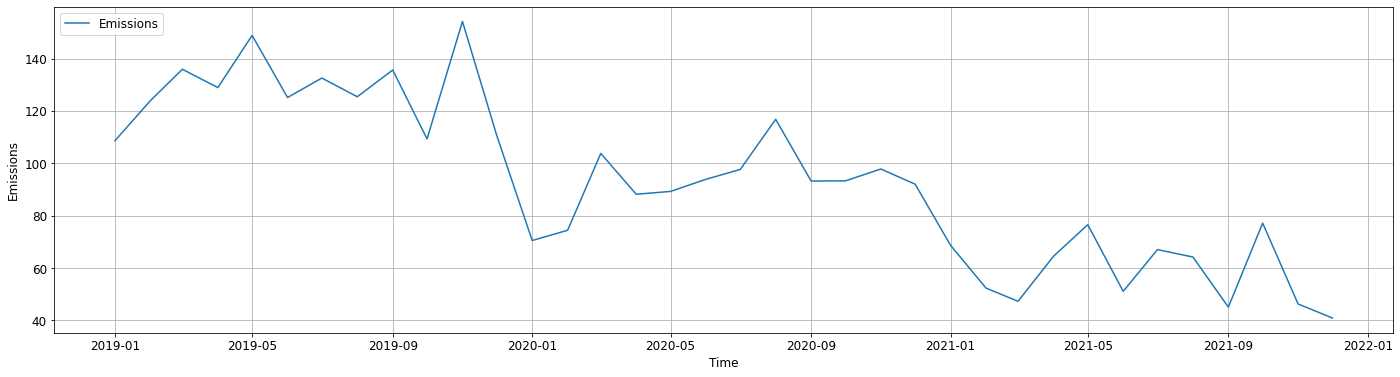

In [186]:
df = tts
sample_asset = 'vehicle101'
df.columns =['item_id','timestamp','target_value']
df = df[df['item_id'] == sample_asset]

pyplot.show()
pyplot.rc('font', size=12)
fig, ax = pyplot.subplots(figsize=(24, 6))

# Specify how our lines should look
ax.plot(df.timestamp, df.target_value, color='tab:blue', label='Emissions')
ax.set_xlabel('Time')
ax.set_ylabel('Emissions')
ax.grid(True)
ax.legend(loc='upper left');


## Save a snapshot of a quality-check-passed data, training data, and validation data in s3 

In [187]:
# Save the time seriestts to S3
local_file = "/home/ec2-user/SageMaker/tts.csv"
# Save merged file locally
tts.to_csv(local_file, header=False, index=False)
print(f"Saved TTS locally to {local_file}")
key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)
print(f"Uploaded TTS to s3://{bucket_name}/{key}")
train_data = tts[tts['timestamp'] <= end_time_train]
validation_data= tts[tts['timestamp'] > end_time_train]
train_data_name = 's3://'+bucket_name+'/training_data.csv'
validation_data_name = 's3://'+bucket_name+'/validation_data.csv'
wr.s3.to_csv(df=train_data,path=train_data_name,header=False, index=False)
wr.s3.to_csv(df=validation_data,path=train_data_name,header=False, index=False)
target_time_series_filename ="training_data.csv"

Saved TTS locally to /home/ec2-user/SageMaker/tts.csv
Uploaded TTS to s3://carbon-lake-forecast-results-354473994411/data/v1/co2_emission_forecast_snap_012021_12_M.csv


## Importing the Dataset to Amazon Forecast

In [165]:
#This will take a while
DATASET_FREQUENCY = "M" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"
project = 'carbon_emission'
datasetName= project+'_aggregated_dataset'
datasetGroupName= project +'_data_group'
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
    
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      }
   ]
}

response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

# Finally we can call import the dataset
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

## Train a predictor

In [173]:
PREDICTOR_NAME = "EMISSION_PREDICTOR"
FORECAST_HORIZON = 3
FORECAST_FREQUENCY = "M"

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = PREDICTOR_NAME,
                                   ForecastHorizon = FORECAST_HORIZON,
                                   ForecastFrequency = FORECAST_FREQUENCY,
                                   DataConfig = {
                                       'DatasetGroupArn': datasetGroupArn
                                    },
                                   ExplainPredictor = True)

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor with ARN {predictor_arn} to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

#status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))
#describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
#print(f"\n\nThe Predictor with ARN {predictor_arn} is now {describe_auto_predictor_response['Status']}.")

Waiting for Predictor with ARN arn:aws:forecast:us-east-1:354473994411:predictor/EMISSION_PREDICTOR_01G1S8BKT7EG3YJPQF9H2F38NZ to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.

Current Status:


AttributeError: module 'util' has no attribute 'wait'

## Get Accuracy Metrics

In [ ]:
get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")

print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")

print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")

print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")

print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

## Generate Forecast for next X months

In [188]:
FORECAST_NAME = "EMISSION_FORECAST"

create_forecast_response = \
    forecast.create_forecast(ForecastName=FORECAST_NAME,
                             PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']
print(f"Waiting for Forecast with ARN {forecast_arn} to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.\n\nCurrent Status:")

#status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn))

#describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
#print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")

Waiting for Forecast with ARN arn:aws:forecast:us-east-1:354473994411:forecast/EMISSION_FORECAST to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.

Current Status:


AttributeError: module 'util' has no attribute 'wait'